In [56]:
import geopandas as gpd
from shapely import LineString, Polygon
import shapely
from shapely import ops
import matplotlib.pyplot as plt
from CPP_Planner import CPP_Algorithms, CPP_Planner_Kit

In [57]:
all_land = gpd.read_file('test_Load_Shp/shp_file/村1地_全区.shp')
# 设定坐标精度为两位小数
all_land.geometry = all_land.geometry.apply(shapely.set_precision, grid_size=0.01)
# all_land.plot()
all_land

,NAME,LAYER,周长,闭合面积,geometry
0,地2,Unknown Area Type,315.38 m,0.001833 sq km,"POLYGON ((440417.610 4397401.440, 440401.830 4..."
1,地3,Unknown Area Type,182.65 m,0.001528 sq km,"POLYGON ((440478.930 4397335.390, 440484.510 4..."
2,地4,Unknown Area Type,247.41 m,0.00125 sq km,"POLYGON ((440472.270 4397608.040, 440469.010 4..."
3,地5,Unknown Area Type,143.98 m,0.000743 sq km,"POLYGON ((440450.070 4397795.260, 440451.860 4..."
4,地6,Unknown Area Type,120.25 m,0.000631 sq km,"POLYGON ((440352.790 4397768.760, 440351.240 4..."
5,地7,Unknown Area Type,147.18 m,0.001222 sq km,"POLYGON ((440315.730 4397785.780, 440309.100 4..."
6,地1_区,Unknown Area Type,442.09 m,0.004246 sq km,"POLYGON ((440410.860 4397414.760, 440398.860 4..."


<Axes: >

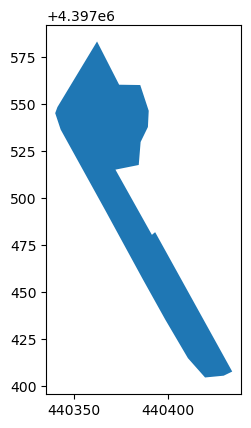

In [58]:
single_land = CPP_Planner_Kit.get_single_shp(all_land, ind=6)
# 这里不进行旋转，因为路径规划的扫描线是针对每一个小凸边形进行的，因此只需要将凸边形们转到水平就好了
# polygon_angle = CPP_Planner_Kit.get_land_MABR_angle(single_land.geometry.iloc[0])
# single_land = single_land.rotate(-polygon_angle, origin='centroid')
single_land.plot()

split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.03
Num of convex_hull:  12
Num of Polygon lines:  20
Not on Convex:  11
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  3
Extending lines...
当前分割多边形个数:  3
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  3
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  2
Num of convex_hull:  7
Num of Polygon lines:  9
Not on Convex:  4
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  2
田块分割结束...


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


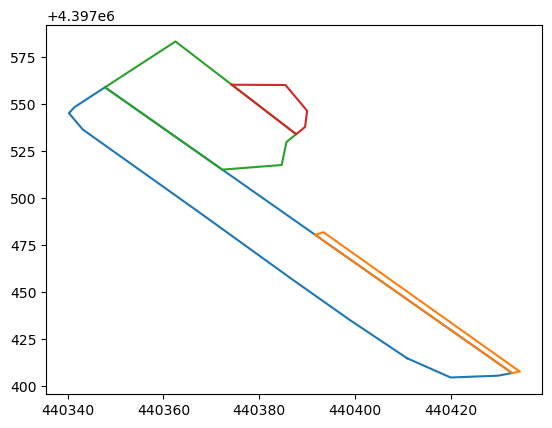

In [59]:
split_polygon = CPP_Planner_Kit.split_polygon_by_largest_area(single_land.geometry.iloc[0])
fig, ax = plt.subplots()
for polygon in split_polygon:
    x, y = polygon.exterior.xy
    ax.plot(x, y)

当前田块角度： 117.064171673677


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


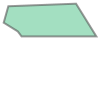

In [60]:
from shapely import affinity
single_polygon = split_polygon[2]
# 将其旋转到水平
single_polygon_angle = CPP_Planner_Kit.get_land_MABR_angle(single_polygon)
single_polygon = affinity.rotate(single_polygon, -single_polygon_angle, origin='centroid')
single_polygon

/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


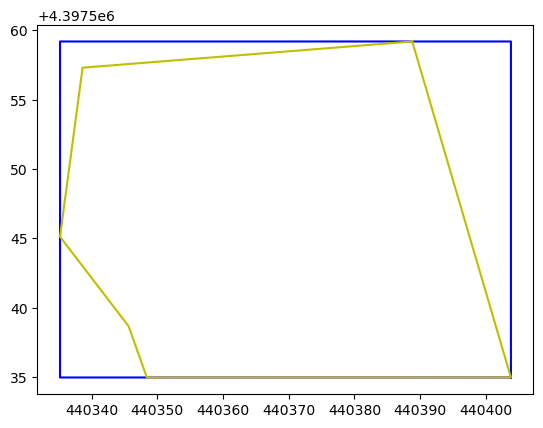

In [61]:
# 显示最小旋转外接矩形和多边形本身
mabr = single_polygon.minimum_rotated_rectangle
fig, ax = plt.subplots()
x, y = mabr.exterior.xy
ax.plot(x, y, 'b')
x, y = single_polygon.exterior.xy
ax.plot(x, y, 'y')

/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


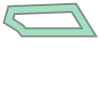

In [62]:
# 缓冲区分析，这里涉及到了 shapely 中的left_side, right_side buffer，可以设置正负号来控制
buffer_distance = -6
boundary = single_polygon.exterior
buffered_boundary = boundary.buffer(buffer_distance, single_sided=True)
head_land = single_polygon.difference(buffered_boundary)
buffered_boundary

In [63]:
# 这里尝试变换图形精度
# single_polygon = shapely.set_precision(single_polygon, 0.05)
x, y = single_polygon.exterior.xy
print(x)
print(y)

array('d', [440388.78711481765, 440403.8000181522, 440377.9724650723, 440348.4149804637, 440345.63849192765, 440335.20269573806, 440338.63611499406, 440388.78711481765])
array('d', [4397559.181495078, 4397534.980760925, 4397534.982142795, 4397534.980239579, 4397538.66724533, 4397545.1222478775, 4397557.292787397, 4397559.181495078])


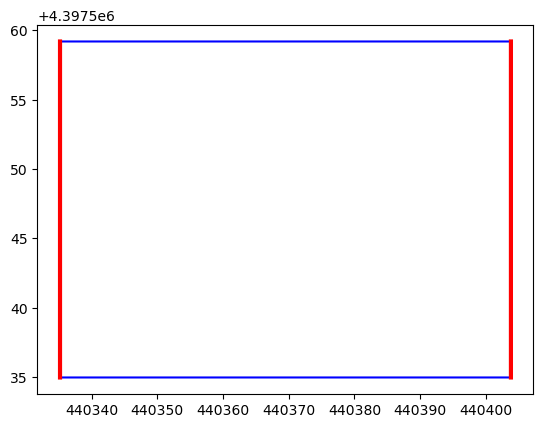

In [64]:
# 通过外包矩形的四个坐标点来确定多边形哪些边属于哪些方向：
# 由于多边形已经根据外包矩形长轴的方向水平化，那么当前MABR的高度就可以筛选出属于“两个短边”的分别的多边形上的边
vertices = list(mabr.exterior.coords)
short_edges = [(vertices[0], vertices[1]), (vertices[2], vertices[3])]
long_edges = [(vertices[1], vertices[2]), (vertices[3], vertices[4])]
for i in range(len(long_edges)):
    long_edges[i] = LineString(long_edges[i])

for i in range(len(short_edges)):
    short_edges[i] = LineString(short_edges[i])
fig, ax = plt.subplots()
ax.plot(*mabr.exterior.xy, 'b')
for edge in short_edges:
    x, y = edge.xy
    ax.plot(x, y, 'r', linewidth=3)

In [65]:
# 获取 MABR 的高度
mabr_height = short_edges[0].length
print(mabr_height)
# 找到这个高度的上点和下点的坐标
up = vertices[2][1]
down = vertices[3][1]
print(f"up: {up}", f" down: {down}")
print(f"up - down: {up - down}")

24.200840567457742
up: 4397559.180879618  down: 4397534.9799780175
up - down: 24.200901600532234


In [66]:
# 找到上点的点集合和下点的点集合
up_points = []
down_points = []
x, y = single_polygon.exterior.xy
for i in range(len(x)):
    print(y[i])
    # if y[i] >= up:
    if abs(y[i] - up) < 0.1:
        up_points.append(i)
    # if y[i] <= down:
    if abs(y[i] - down) < 0.1:
        down_points.append(i)
print("up_points: ", up_points)
print("down_points: ", down_points)
for i in range(len(up_points)):
    up_points[i] = [x[up_points[i]], y[up_points[i]]]
for i in range(len(down_points)):
    down_points[i] = [x[down_points[i]], y[down_points[i]]]
print("up_points: ", up_points)
print("down_points: ", down_points)

4397559.181495078
4397534.980760925
4397534.982142795
4397534.980239579
4397538.66724533
4397545.1222478775
4397557.292787397
4397559.181495078
up_points:  [0, 7]
down_points:  [1, 2, 3]
up_points:  [[440388.78711481765, 4397559.181495078], [440388.78711481765, 4397559.181495078]]
down_points:  [[440403.8000181522, 4397534.980760925], [440377.9724650723, 4397534.982142795], [440348.4149804637, 4397534.980239579]]


In [67]:
from shapely.geometry import Point
# 遍历当前 single_polygon 的所有边
# 获取多边形的外部环
exterior = single_polygon.exterior

long_edge_up = long_edges[0]
long_edge_down = long_edges[1]
print("long edge up: ", long_edge_up)
print("long edge down: ", long_edge_down)


touch_up_edges = []
touch_down_edges = []


# 迭代外部环的坐标序列
for i in range(len(exterior.coords) - 1):
    # 获取相邻的坐标点
    point1 = exterior.coords[i]
    point2 = exterior.coords[i + 1]
    temp_edge = LineString((point1, point2))
    print("边:", temp_edge)
    if temp_edge.intersection(long_edge_up):
        print("在上边界上")
        touch_up_edges.append(temp_edge)
    # if temp_edge.intersection(long_edge_down):
    #     print("在下边界上")
    #     touch_down_edges.append(temp_edge)
for i in range(len(exterior.coords) - 1):
    # 获取相邻的坐标点
    point1 = exterior.coords[i]
    point2 = exterior.coords[i + 1]
    temp_edge = LineString((point1, point2))
    print("边:", temp_edge)
    if temp_edge.intersection(long_edge_down):
        print("在下边界上")
        touch_down_edges.append(temp_edge)

long edge up:  LINESTRING (440403.799860406 4397559.181507643, 440335.20260191686 4397559.180879618)
long edge down:  LINESTRING (440335.2028378902 4397534.9799780175, 440403.8000963788 4397534.980667077)
边: LINESTRING (440388.78711481765 4397559.181495078, 440403.8000181522 4397534.980760925)
在上边界上
边: LINESTRING (440403.8000181522 4397534.980760925, 440377.9724650723 4397534.982142795)
边: LINESTRING (440377.9724650723 4397534.982142795, 440348.4149804637 4397534.980239579)
边: LINESTRING (440348.4149804637 4397534.980239579, 440345.63849192765 4397538.66724533)
边: LINESTRING (440345.63849192765 4397538.66724533, 440335.20269573806 4397545.1222478775)
边: LINESTRING (440335.20269573806 4397545.1222478775, 440338.63611499406 4397557.292787397)
边: LINESTRING (440338.63611499406 4397557.292787397, 440388.78711481765 4397559.181495078)
在上边界上
边: LINESTRING (440388.78711481765 4397559.181495078, 440403.8000181522 4397534.980760925)
边: LINESTRING (440403.8000181522 4397534.980760925, 440377.972

/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


touch up edges:  [<LINESTRING (440388.787 4397559.181, 440403.8 4397534.981)>, <LINESTRING (440338.636 4397557.293, 440388.787 4397559.181)>]
touch down edges:  []


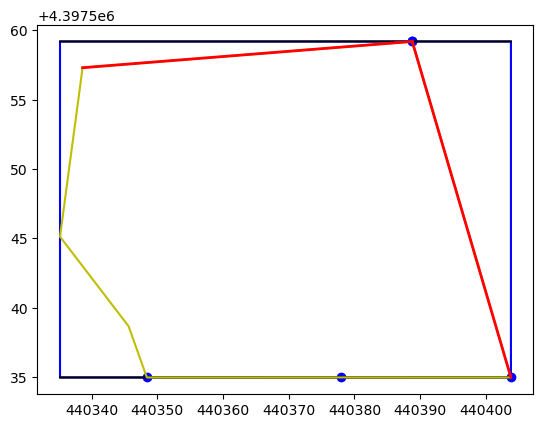

In [68]:
# 显示出来看看
print("touch up edges: ", touch_up_edges)
print("touch down edges: ", touch_down_edges)
fig, ax = plt.subplots()
ax.plot(*mabr.exterior.xy, 'b')
ax.plot(*long_edge_up.xy, 'black')
ax.plot(*long_edge_down.xy, 'black')
ax.plot(*single_polygon.exterior.xy, 'y')
for up_edge in touch_up_edges:
    ax.plot(*up_edge.xy, 'r', linewidth=2)
for down_edge in touch_down_edges:
    ax.plot(*down_edge.xy, 'g')

x_coords = [point[0] for point in up_points]
y_coords = [point[1] for point in up_points]
ax.scatter(x_coords, y_coords, c='blue')
x_coords = [point[0] for point in down_points]
y_coords = [point[1] for point in down_points]
ax.scatter(x_coords, y_coords, c='blue')

In [69]:
# all_land.geometry = all_land.geometry.apply(shapely.set_precision, grid_size=0.01)
all_land

,NAME,LAYER,周长,闭合面积,geometry
0,地2,Unknown Area Type,315.38 m,0.001833 sq km,"POLYGON ((440417.610 4397401.440, 440401.830 4..."
1,地3,Unknown Area Type,182.65 m,0.001528 sq km,"POLYGON ((440478.930 4397335.390, 440484.510 4..."
2,地4,Unknown Area Type,247.41 m,0.00125 sq km,"POLYGON ((440472.270 4397608.040, 440469.010 4..."
3,地5,Unknown Area Type,143.98 m,0.000743 sq km,"POLYGON ((440450.070 4397795.260, 440451.860 4..."
4,地6,Unknown Area Type,120.25 m,0.000631 sq km,"POLYGON ((440352.790 4397768.760, 440351.240 4..."
5,地7,Unknown Area Type,147.18 m,0.001222 sq km,"POLYGON ((440315.730 4397785.780, 440309.100 4..."
6,地1_区,Unknown Area Type,442.09 m,0.004246 sq km,"POLYGON ((440410.860 4397414.760, 440398.860 4..."


In [70]:
# 现在已经找到了在 MABR 上边界和下边界的四个点，现在需要找到“左右两侧的边”，找出对应的边
print(up_points)
print(down_points)
# try
left_begin_point = down_points[-1]
left_end_point = up_points[0]
right_begin_point = up_points[0]
right_end_point = down_points[-1]
print([left_begin_point, left_end_point])
print([right_begin_point, right_end_point])

[[440388.78711481765, 4397559.181495078], [440388.78711481765, 4397559.181495078]]
[[440403.8000181522, 4397534.980760925], [440377.9724650723, 4397534.982142795], [440348.4149804637, 4397534.980239579]]
[[440348.4149804637, 4397534.980239579], [440388.78711481765, 4397559.181495078]]
[[440388.78711481765, 4397559.181495078], [440348.4149804637, 4397534.980239579]]


In [71]:
# 测试： 做差集，将所有在 MABR 上的点和原多边形做差集合
if len(up_points) == 1:
    up_geom = Point(up_points[0])
else:
    up_geom = LineString(up_points)

if len(down_points) == 1:
    down_geom = Point(down_points[0])
else:
    down_geom = LineString(down_points)
print("up: ", type(up_geom))
print("down: ", type(down_geom))

up:  <class 'shapely.geometry.linestring.LineString'>
down:  <class 'shapely.geometry.linestring.LineString'>


AttributeError: 'LineString' object has no attribute 'x'

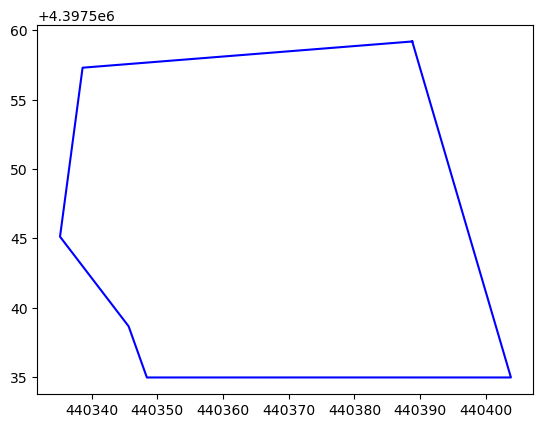

In [73]:
fig, ax = plt.subplots()
plt.plot(*single_polygon.exterior.xy, c='b')
plt.scatter(up_geom.x, up_geom.y, c='y')
plt.plot(*down_geom.xy, c='y')

In [ ]:
# 可以使用 buffer 来设定缓冲区，避免找不到
up_geom.buffer(0.1)
down_geom.buffer(0.1)

In [ ]:
boundary = list(single_polygon.exterior.coords)
split_index = boundary.index((left_begin_point, left_begin_point))
# 分割线段
segment_1 = boundary[:split_index + 1]
segment_2 = boundary[split_index:] + [boundary[0]]
# 构建分割后的两个线段对象
line1 = LineString(segment_1)
line2 = LineString(segment_2)
fig, ax = plt.subplots()
ax.plot(*line1.xy)

In [ ]:
print(single_polygon)